# Dentate Gyrus development

In [1]:
import shutup
shutup.please()

import math
import scanpy as sc
import scvelo as scv
import matplotlib.pyplot as plt
from tivelo import tivelo
from baseline import run_baseline
from tivelo.plotting.velo_vec_plot import scatter_gene

(Running UniTVelo 0.2.5.2)
2024-07-05 08:25:47


2024-07-05 16:25:48.672487: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-05 16:25:48.747193: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-05 16:25:48.747219: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Run TIVelo
Load the dataset.

In [2]:
# load preprocessed dataset
data_name = "dentategyrus"
data_path = "/lustre/project/Stat/s1155202250ShareData/datamuyang/DentateGyrus/10X43_1_processed.h5ad"
adata = sc.read(data_path)

Here the data has been preprocessed by the standard pipeline of scvelo as the following:
```
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
```

However, sometimes there will be some issues. To avoid that, we can use the following instead:

```
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
sc.pp.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)
```

Set the data name with key for cluster, key for embedding and cluster edges (for comparison).

In [3]:
group_key = "clusters"
emb_key = "X_umap"
cluster_edges = [("nIPC", "Neuroblast"), ("Neuroblast", "Granule immature"), ("Granule immature", "Granule mature"),
                 ('OPC', 'OL')]

Set the model parameters. 
To measure the model performance, it requires the input cluster edges to see if the velocity stream is consistent with the given direction of edges. Set measure_performance = True.

In [4]:
save_folder = "results"
show_fig = True
filter_genes = True
save_coeff = True
constrain = True
loss_fun = "mse"
only_s = False
alpha_1 = 1
alpha_2 = 0.1
batch_size = 1024
n_epochs = 100

tree_gene = "Cplx2"
show_DTI = True
adjust_DTI = False
velocity_key = "velocity"
measure_performance = True

Run the model by function tivelo.

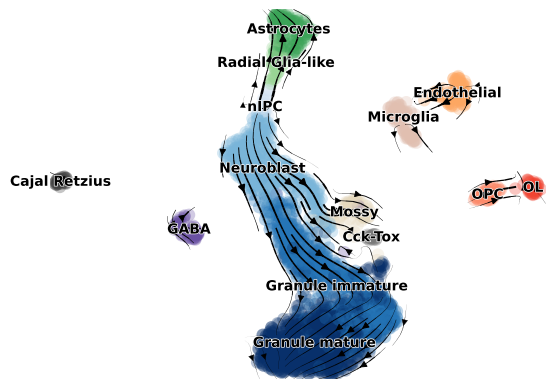

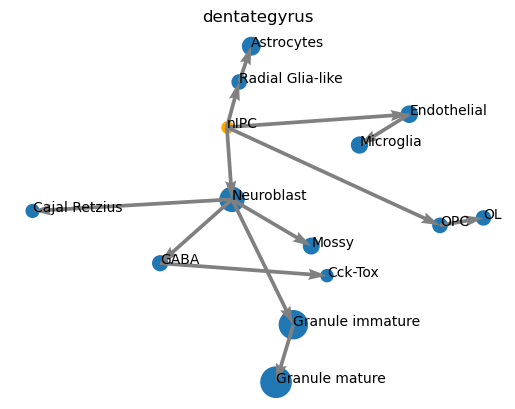

TIVelo:
 CBDir: 0.4160 ICVCoh: 0.7515 
 CBDir2: 0.4327 ICVCoh2: 0.5615 
 TransProbs: 0.4013 VeloCoh: 0.2820


In [5]:
adata_ = tivelo(adata, group_key, emb_key, data_name=data_name, save_folder=save_folder, njobs=64, tree_gene=tree_gene,
                show_fig=show_fig, filter_genes=filter_genes, constrain=constrain, loss_fun=loss_fun, only_s=only_s,
                alpha_1=alpha_1, alpha_2=alpha_2, batch_size=batch_size, n_epochs=n_epochs, velocity_key="velocity",
                adjust_DTI=adjust_DTI, show_DTI=show_DTI, cluster_edges=cluster_edges, 
                measure_performance=measure_performance)

Generate the scatter $u$-$s$ plot for single genes.

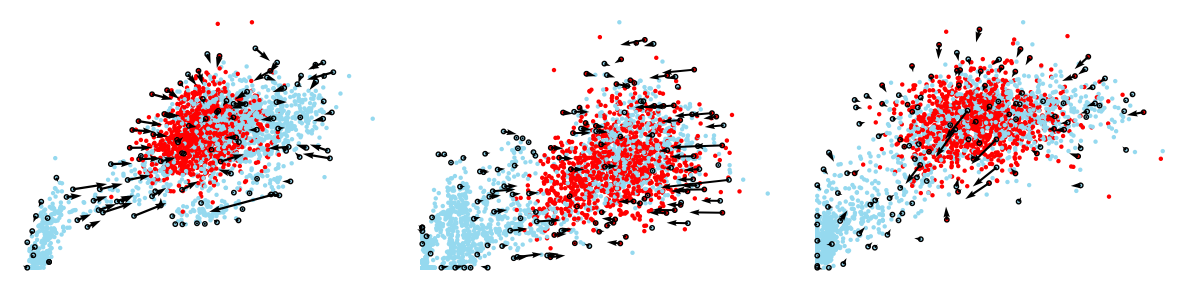

In [6]:
ncols = 3
gene_list = ["Map1b", "Cplx2", "Ak5"]
height = math.ceil(len(gene_list) / ncols) * 3
fig = plt.figure(figsize=(4 * ncols, height))

for i in range(len(gene_list)):
    ax = fig.add_subplot(math.ceil(len(gene_list) / ncols), ncols, i + 1)
    scatter_gene(adata_, velocity_key="velocity", gene_name=gene_list[i], ax=ax, color=group_key,
                 key_cluster="Granule mature", length_scale=5)
    ax.axis('off')

fig.tight_layout()
plt.savefig(save_folder + "/{}/figs/scatter_genes.png".format(data_name))

## Run scVelo

Stochastic mode.

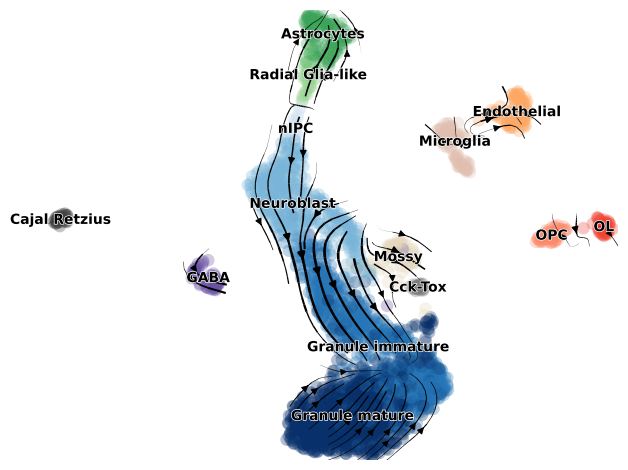

scvelo:
 CBDir: 0.1762 ICVCoh: 0.9204 
 CBDir2: 0.0371 ICVCoh2: 0.6100 
 TransProbs: 0.1308 VeloCoh: 0.0289


In [7]:
adata_scvelo = run_baseline(adata, "scvelo", data_name, group_key, emb_key, cluster_edges, show_fig=True,
                            measure_performance=True)

Dynamical mode.

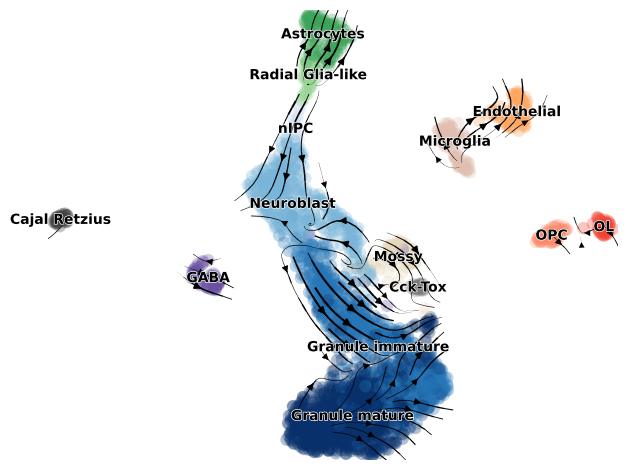

scvelo2:
 CBDir: 0.1618 ICVCoh: 0.8531 
 CBDir2: 0.1834 ICVCoh2: 0.5779 
 TransProbs: 0.2316 VeloCoh: 0.0097


In [8]:
adata_scvelo2 = run_baseline(adata, "scvelo2", data_name, group_key, emb_key, cluster_edges, show_fig=True,
                            measure_performance=True)

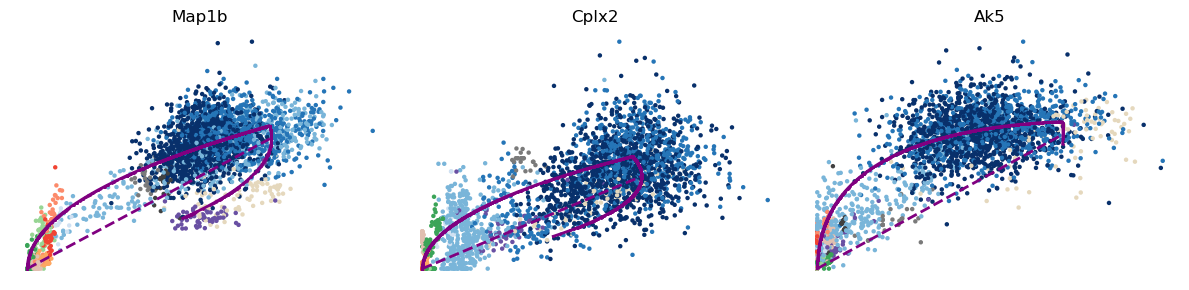

In [9]:
ncols = 3
gene_list = ["Map1b", "Cplx2", "Ak5"]
height = math.ceil(len(gene_list) / ncols) * 3
fig = plt.figure(figsize=(4 * ncols, height))
kwargs = dict(linewidth=2, add_linfit=True, frameon=False)

for i in range(len(gene_list)):
    ax = fig.add_subplot(math.ceil(len(gene_list) / ncols), ncols, i + 1)
    ax = scv.pl.scatter(adata_scvelo2, basis=gene_list[i], ax=ax, show=False, add_outline='fit_diff_kinetics',
                        title="", **kwargs)
    ax.set_title(gene_list[i])
    ax.get_legend().remove()

fig.tight_layout()
plt.savefig(save_folder + "/{}/figs/scatter_genes_scvelo.png".format(data_name))

## Run veloVI.

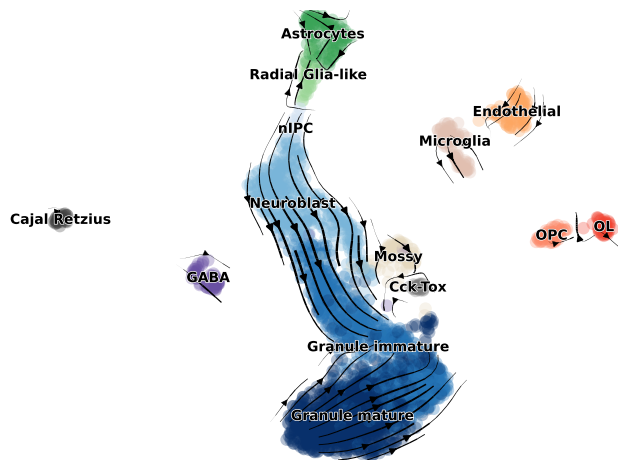

velovi:
 CBDir: 0.5099 ICVCoh: 0.8860 
 CBDir2: 0.0831 ICVCoh2: 0.6645 
 TransProbs: 0.0877 VeloCoh: 0.1425


In [10]:
adata_velovi = run_baseline(adata, "velovi", data_name, group_key, emb_key, cluster_edges, show_fig=True,
                            measure_performance=True)

## Run UniTVelo.

We have provided a uniform API to test TIVelo and other methods . You can use the following code to test UniTVelo:
> Note: Ensure that you install the UniTVelo dependencies by following the [official instructions](https://unitvelo.readthedocs.io/en/latest/install.html).

In [14]:
adata_unitvelo = run_baseline(adata, "unitvelo", data_name, group_key, emb_key, cluster_edges, show_fig=True, measure_performance=True)

------> Manully Specified Parameters <------
MAX_ITER:	10000
------> Model Configuration Settings <------
N_TOP_GENES:	2000
LEARNING_RATE:	0.01
FIT_OPTION:	1
DENSITY:	SVD
REORDER_CELL:	Soft_Reorder
AGGREGATE_T:	True
R2_ADJUST:	True
GENE_PRIOR:	None
VGENES:	basic
IROOT:	None
--------------------------------------------

Current working dir is /lustre/project/Stat/s1155202250/fastfolder/code/muyang/tivelo/docs/source/notebooks/notebooks.
Results will be stored in res folder
Filtered out 176 genes that are detected 20 counts (shared).
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
Logarithmized X.
Extracted 1824 highly variable genes.
Computing moments for 1824 genes with n_neighbors: 30 and n_pcs: 30
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)

# of velocity genes 855 (Criterion: positive regression coefficient between un/spliced counts)
# of velocity ge

ImportError: `keras.optimizers.legacy` is not supported in Keras 3. When using `tf.keras`, to continue using a `tf.keras.optimizers.legacy` optimizer, you can install the `tf_keras` package (Keras 2) and set the environment variable `TF_USE_LEGACY_KERAS=True` to configure TensorFlow to use `tf_keras` when accessing `tf.keras`.

## Run cellDancer

We have provided a uniform API to test TIVelo and other methods . You can use the following code to test CellDancer:
> Note: Ensure that you install the UniTVelo dependencies by following the [official cellDancer instructions](https://guangyuwanglab2021.github.io/cellDancer_website/notebooks/installation.html).



To run cellDancer, it requires to first use celldancer.utilities.adata_to_df_with_embed to turn adata to dataframe as follows:

Then use celldancer.velocity for velocity genes filtered by function "compute_velocity_genes" in utils/velocity_genes.py. 

Finally, get the result by celldancer.compute_cell_velocity and save it to "save_folder + "data_name/celldancer/data_name.csv".

Note that to test cellDancer, please install the package celldancer and comment out line 747 and 748
of the file celldancer/velocity_estimation.py, and add a line after line 748: folder_name = "cellDancer_velocity".

In [13]:
adata_celldancer = run_baseline(adata, "celldancer", data_name, group_key, emb_key, cluster_edges, show_fig=True,
                                measure_performance=True)

FileNotFoundError: No celldancer output file found at results